In [2]:
import torch
import matplotlib.pyplot as plt



In [3]:
e = torch.linspace(0, 16, 1000)
x = torch.linspace(0, 1, 1000) ** e

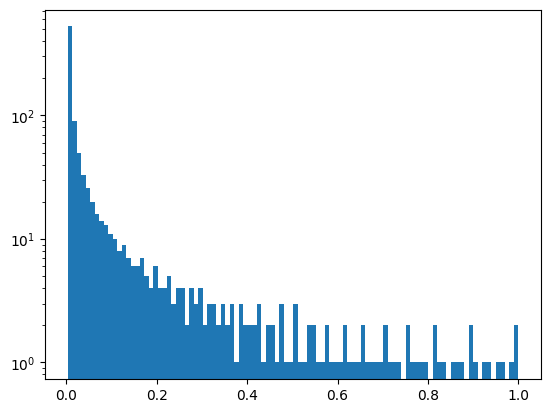

In [4]:
plt.hist(x.numpy(), bins=100)   
plt.yscale('log')
plt.show()

tensor(-0.) tensor(17.) 18
tensor(-0.) tensor(17.) 18
tensor(-0.) tensor(17.) 18
tensor(-0.) tensor(17.) 18


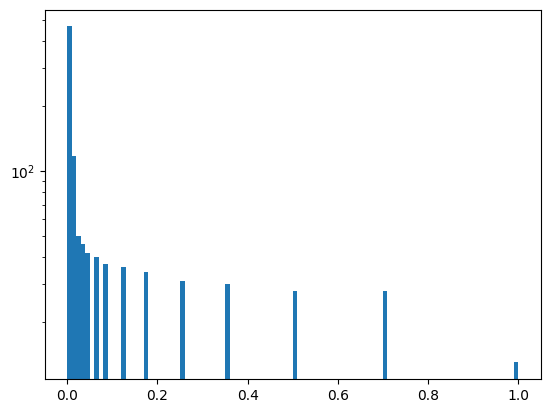

In [5]:
def quantize(x, delta):
    from math import sqrt
    n_levels = 2 ** 4
    x_int = torch.round(-1 * (x / delta).log2() * 2)
    print(
        x_int.min(),
        x_int.max(),
        torch.unique(x_int).numel(),
    )
    mask = x_int >= n_levels
    x_quant = torch.clamp(x_int, 0, n_levels - 1)
    odd_mask = (x_quant % 2) * (sqrt(2) - 1) + 1
    x_float_q = 2 ** (-1 * torch.ceil(x_quant / 2)) * odd_mask * delta
    x_float_q[mask] = 0

    return x_float_q

def init_quantization_scale( x: torch.Tensor):
    import numpy as np
    delta = None
    x_clone = x.clone().detach()
    delta = x_clone.max()
    best_score = 1e10
    for pct in [0.999, 0.9999, 0.99999]:  #
        try:
            new_delta = torch.quantile(x_clone.reshape(-1), pct)
        except:
            new_delta = torch.tensor(
                np.percentile(x_clone.reshape(-1).cpu(), pct * 100),
                device=x_clone.device,
                dtype=torch.float32,
            )
        x_q = quantize(x_clone, new_delta)
        # score = lp_loss(x_clone, x_q, p=2, reduction="all")
        score = torch.norm(x_clone - x_q, p=2)
        if score < best_score:
            best_score = score
            delta = new_delta
        
    return delta

delta = init_quantization_scale(x)
dja = quantize(x, delta)
plt.hist(dja.numpy(), bins=100)
plt.yscale('log')
plt.show()

torch.Size([59610624])
torch.Size([59610624])


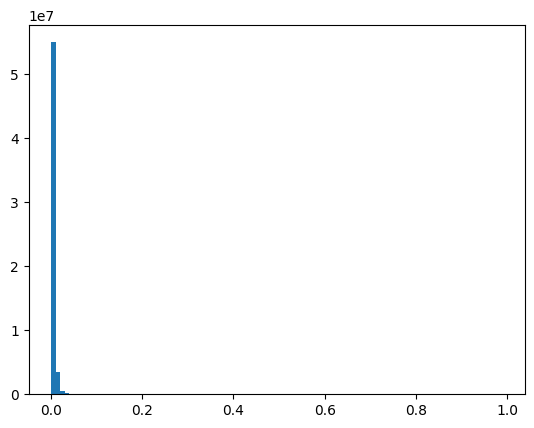

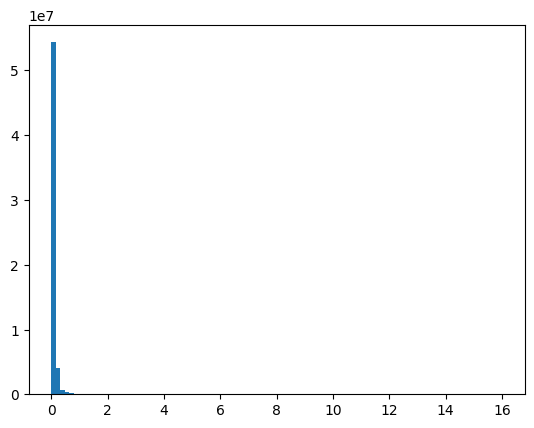

In [9]:
attn = torch.load('x_hat.pt').cpu().flatten()
print(attn.shape)
attnlogquantout = torch.load('x_quant.pt').cpu().flatten()
print(attnlogquantout.shape)


plt.hist(attn.numpy(), bins=100)
plt.show()
plt.hist(attnlogquantout.numpy(), bins=100)


plt.show()